In [1]:
import re
import os
from tqdm.auto import tqdm
from sentence_transformers import evaluation
import torch 
from transformers import BertModel
from transformers import BertTokenizer
from datasets import Dataset
import pandas as pd
from transformers.optimization import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt 
import numpy as np
import sklearn.model_selection
import sklearn
from sentence_transformers import SentenceTransformer, InputExample, losses, util

In [2]:
#load data 
df = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/enTrainData.csv", sep="\t")
df = df.loc[(df["url1_lang"] == "en") & (df["url2_lang"] == "en")]

#put ground truth values into a list 
df["ground_truth"] = df['Overall']


Text(0, 0.5, 'count')

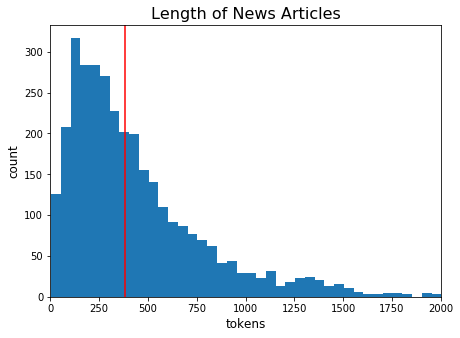

In [3]:
fig, axs = plt.subplots(figsize=[7, 5])
len1 = list(df.dropna()["text1"].apply(lambda x: len(x.split())))
len2 = list(df.dropna()["text2"].apply(lambda x: len(x.split())))
plt.hist(len1 + len2, bins=200)
plt.axvline(384, color="red")
plt.xlim([0, 2000])
plt.title("Length of News Articles", size=16)
plt.xlabel("tokens", size=12)
plt.ylabel("count", size=12)

4.0

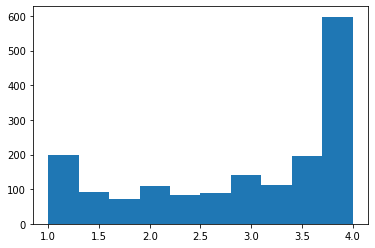

In [4]:
plt.hist(df["ground_truth"])
min(df["ground_truth"])
max(df["ground_truth"])

In [5]:

#TODO: do we need to make data tensors or does this happen when we call set_format() later on
#df["ground_truth"] = df["ground_truth"].apply(torch.tensor)

#[torch.tensor(gtList) for gtList in df["ground_truth"]]

#get only the columns we need 
#TODO: do we need "pair_id"? 
leanDf = df[["ground_truth",  'text1', 'text2']].dropna()
print(min(leanDf["ground_truth"]))
#rescale data from (0, 4): (0, 1)
leanDf["ground_truth"] = 1 - ((leanDf["ground_truth"] - 1) / 3)


1.0


(array([593., 189., 113., 139.,  75.,  98., 110.,  71.,  91., 197.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

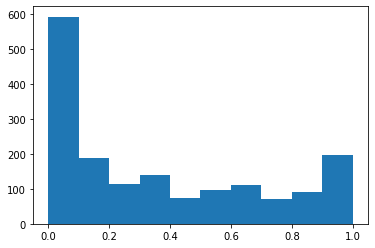

In [6]:
plt.hist(leanDf["ground_truth"])

In [7]:
max(leanDf["ground_truth"])

1.0

In [8]:
deviceNum = 4
def check_mem():
    torch.cuda.empty_cache()
    a = torch.cuda.memory_allocated(deviceNum)/1024/1024/1024
    r = torch.cuda.memory_reserved(deviceNum)/1024/1024/1024
    print("torch.cuda.memory_allocated: %fGB"%a)
    print("torch.cuda.memory_reserved: %fGB"%r)
    print("torch.cuda.memory_free: %fGB"%(r-a))
    print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(deviceNum)/1024/1024/1024))
check_mem()

#split data 
trainDf, validDf = sklearn.model_selection.train_test_split(leanDf, train_size=.75, test_size=.25)
trainDf = trainDf.reset_index(drop=True)
trainDf.head(2)

print("Train Rows: " + str(trainDf.shape[0]))
print("Validation Rows: "  + str(validDf.shape[0]))

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.memory_free: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB
Train Rows: 1257
Validation Rows: 419


In [9]:
#TODO: figure out how to keep punctuation after splitting 
#TODO: also it seems broken... 
MAX_LEN = 384
def splitText(inStr): 
    #matches combinations of punctuation of any length (e.g. !??..??! would match)
    #sents = re.split("[.!?]+", inStr)
    sents = re.findall(".*?[.!?]+", inStr)
    trainExamples = []
    chunkIter = 0
    currLen = 0 
    currText = ""
    #print(sents)
    while chunkIter < len(sents): 
        
        #Add the chunk/sentence to the current training example we are making 
        #current chunk/sentence we want to add 
        currChunk = sents[chunkIter]
        #print("------------------------------")
        #print(currChunk)
        #check how long our string would be if we added this chunk 
        potLen = currLen + len(currChunk.split())
        #print(potLen)
        if potLen < MAX_LEN: 
            #print("less than")
            #add the sentance to the current string (training example)
            #print("added " + currChunk + " to " + currText)
            currText += currChunk
            
        else: 
            #add the current training string to the list of train examples and then set
            #it to an empty string again 
            #print(str(potLen) + " > " + str(MAX_LEN))
            trainExamples.append(currText)
            currText = currChunk
            
        #get the current length of our training example 
        currLen = len(currText.split())
        
        #always want to move to the next chunk 
        chunkIter += 1
    
    #the last portion won't get added so we add it here 
    trainExamples.append(currText)
    #print(trainExamples)
    return trainExamples 

testExample = "Hello everyone!!!? How's it going? Yep... Here we are.? "
print(splitText(testExample))

["Hello everyone!!!? How's it going? Yep... Here we are.?"]


In [10]:
#now chunked version of test data 
trainChunked = trainDf.copy(deep=True)
trainChunked["text1"] = trainChunked["text1"].apply(splitText)
trainChunked = trainChunked.explode(column="text1")

trainChunked["text2"] = trainChunked["text2"].apply(splitText)
trainChunked = trainChunked.explode(column="text2")

In [11]:
#we want to create chunked and unchunked versions of the validation data
#chunked version of training first 
validChunked = validDf.copy(deep=True)
validChunked["text1"] = validChunked["text1"].apply(splitText)
validChunked = validChunked.explode(column="text1")

validChunked["text2"] = validChunked["text2"].apply(splitText)
validChunked = validChunked.explode(column="text2")

In [12]:
trainProp = len(trainChunked) / (len(trainChunked) + len(validChunked))
print("Train Proportion: " + str(trainProp))
print("Validation Proportion: " + str(1 - trainProp))

Train Proportion: 0.7221506761107533
Validation Proportion: 0.27784932388924666


In [13]:
#now get all the lengths of our training and validation 
trainChunked["len1"] = trainChunked["text1"].apply(lambda x: len(x.split()))
trainChunked["len2"] = trainChunked["text2"].apply(lambda x: len(x.split()))
validChunked["len1"] = validChunked["text1"].apply(lambda x: len(x.split()))
validChunked["len2"] = validChunked["text2"].apply(lambda x: len(x.split()))


Text(0.5, 0, 'tokens')

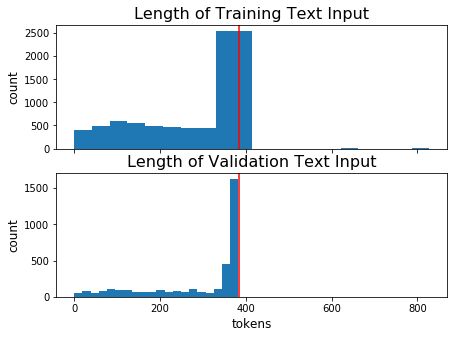

In [14]:
#note we have more examples because there are doubles but that is fine for showing length distribution 
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[7, 5], sharex=True)
axs[0].hist(list(trainChunked["len1"]) + list(trainChunked["len2"]), bins =20)
axs[0].axvline(384, color="red")
axs[0].set_title("Length of Training Text Input", size=16)
axs[0].set_ylabel("count", size=12)
axs[1].hist(list(validChunked["len1"]) + list(validChunked["len2"]), bins =20)
axs[1].axvline(384, color="red")
axs[1].set_title("Length of Validation Text Input", size=16)
axs[1].set_ylabel("count", size=12)
axs[1].set_xlabel("tokens", size=12)

In [15]:
trainExamples = []
for row in trainChunked.itertuples(): 
    trainExamples.append(InputExample(texts =[row[2], row[3]], label=row[1]))

In [16]:
len(trainExamples)

4486

In [18]:
#fit model!
torch.cuda.empty_cache()

#del model
#os.rmdir("/home/blitt/projects/localNews/models/sentEmbeddings/0.1-mpNetCosSimChunked/output")
#os.rmdir("/home/blitt/projects/localNews/models/sentEmbeddings/0.1-mpNetCosSimChunked/checkpoint")
check_mem()

model = SentenceTransformer('all-mpnet-base-v2', device="cuda:" + str(deviceNum))

#Define your train examples. You need more than just two examples...
#train_examples = [InputExample(texts=['My first sentence', 'My second sentence'], label=0.8),
#    InputExample(texts=['Another pair', 'Unrelated sentence'], label=0.3)]

#Define your train dataset, the dataloader and the train loss
train_dataloader = torch.utils.data.DataLoader(trainExamples, shuffle=True, batch_size=8)

#works OK 
#train_loss = losses.MultipleNegativesRankingLoss(model)

train_loss = losses.CosineSimilarityLoss(model)

evaluator = evaluation.EmbeddingSimilarityEvaluator(list(validChunked["text1"]), list(validChunked["text2"]), list(validChunked["ground_truth"]))

check_mem()

#Tune the model
#"/shared/3/projects/benlitterer/localNews/NetworkMVP/SBERTstockEval"
output_path = "/home/blitt/projects/localNews/models/sentEmbeddings/0.1-mpNetCosSimChunked/output"
checkpoint_path = "/home/blitt/projects/localNews/models/sentEmbeddings/0.1-mpNetCosSimChunked/checkpoint"
evaluation_steps = 100
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=2, warmup_steps=75, evaluator=evaluator, evaluation_steps = evaluation_steps, output_path=output_path, checkpoint_path=checkpoint_path, save_best_model=True)

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.memory_free: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB
torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.memory_free: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/561 [00:00<?, ?it/s]

Iteration:   0%|          | 0/561 [00:00<?, ?it/s]

In [19]:
evalData = pd.read_csv("/home/blitt/projects/localNews/models/sentEmbeddings/0.1-mpNetCosSimChunked/output/eval/similarity_evaluation_results.csv")

In [36]:
evalData

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,0,100,0.770613,0.751737,0.754301,0.751737,0.756895,0.754879,0.770613,0.751737
1,0,200,0.789416,0.773447,0.770439,0.773447,0.772785,0.774302,0.789416,0.773447
2,0,300,0.787416,0.768796,0.770764,0.768796,0.773842,0.770843,0.787416,0.768796
3,0,400,0.803578,0.784727,0.788454,0.784728,0.791115,0.786641,0.803578,0.784728
4,0,500,0.798352,0.779730,0.781158,0.779730,0.782837,0.779177,0.798352,0.779730
5,0,-1,0.796084,0.773452,0.779945,0.773452,0.781614,0.773674,0.796084,0.773452
6,1,100,0.803928,0.783792,0.785554,0.783792,0.787291,0.784185,0.803928,0.783792
7,1,200,0.803203,0.783370,0.784276,0.783370,0.786708,0.784224,0.803203,0.783370
8,1,300,0.805612,0.785080,0.786348,0.785080,0.788579,0.785802,0.805612,0.785079
9,1,400,0.808631,0.787131,0.790769,0.787131,0.792687,0.787608,0.808631,0.787131


In [20]:
#TODO: change output path so we don't get this. Create whole new folder for this model..? 

In [46]:
plotDat

0     0.178253
1     0.356506
2     0.534759
3     0.713012
4     0.891266
6     1.178253
7     1.356506
8     1.534759
9     1.713012
10    1.891266
dtype: float64

<ipython-input-48-d8c2233358b3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotData["totalSteps"] = totalSteps


Text(0, 0.5, 'Pearson Correlation')

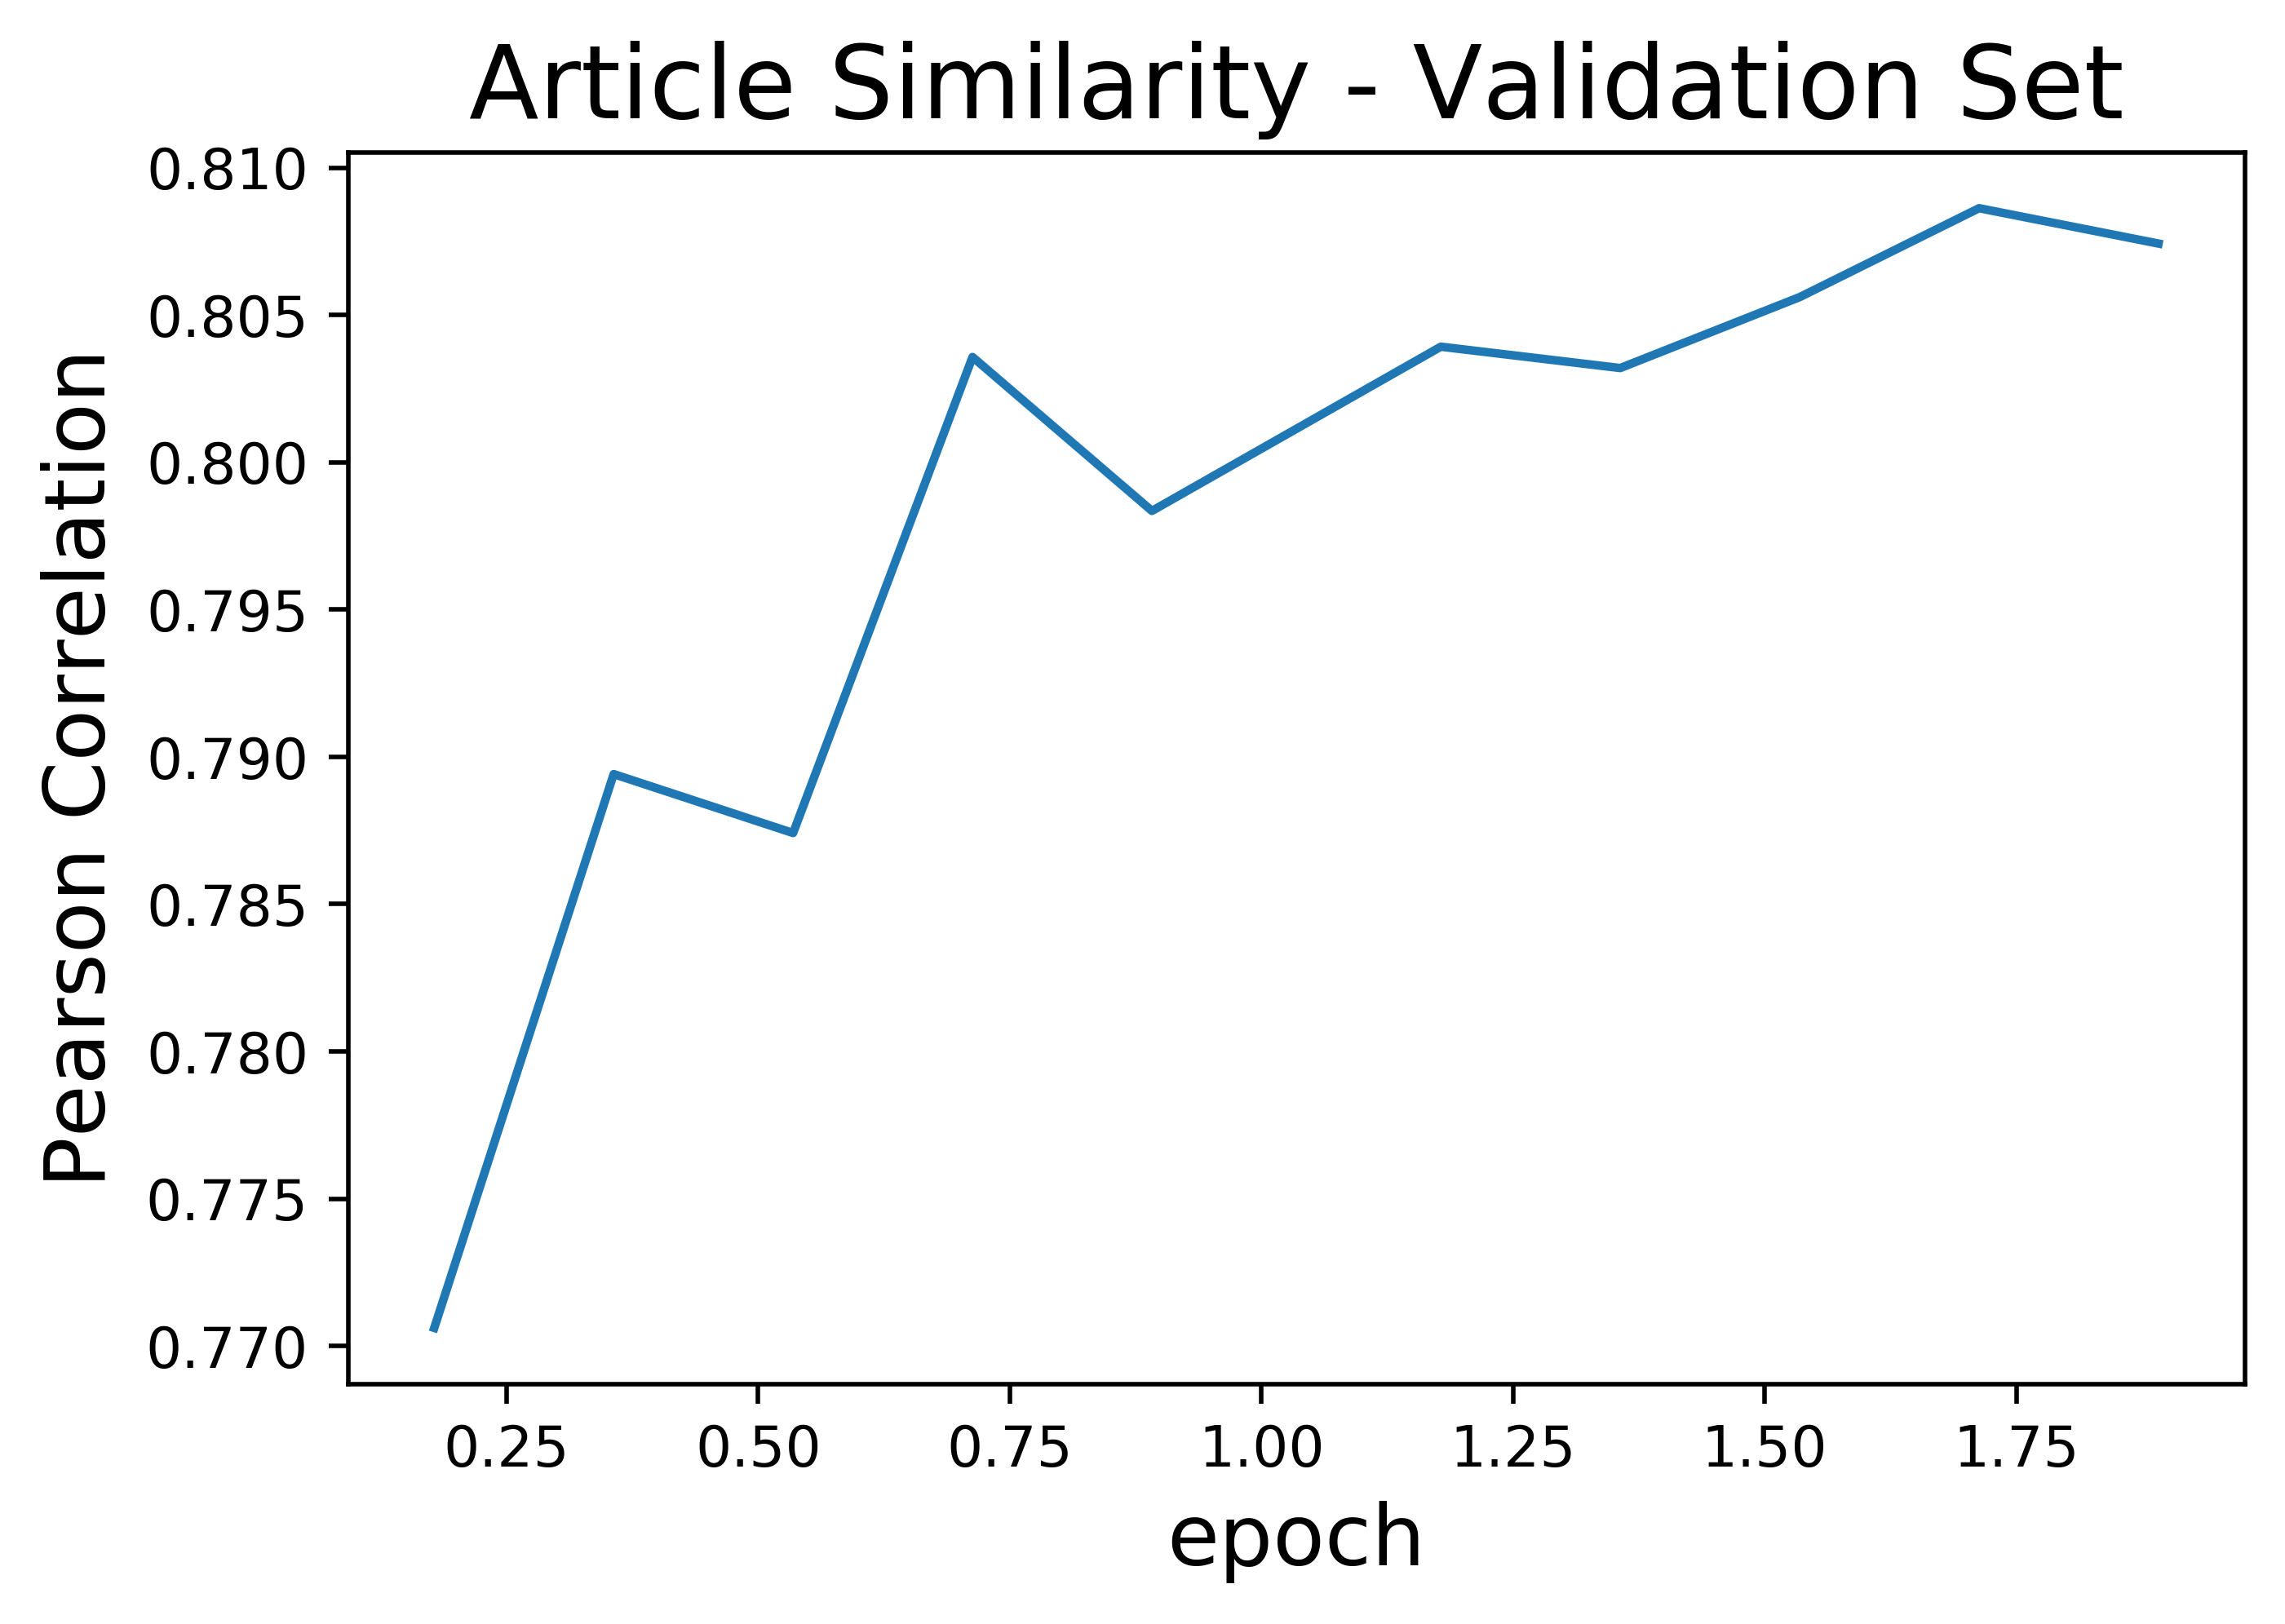

In [48]:
EPOCH_SIZE = 561
EVALUATION_STEPS = evaluation_steps 

#format the data in dataframe 
plotData = evalData[evalData["steps"] != -1]
currStep = 0 
totalSteps = (plotData["steps"] / EPOCH_SIZE) + plotData["epoch"]

    
plotData["totalSteps"] = totalSteps

#plot eval 
plt.rcParams['figure.dpi'] = 500
plt.plot(plotData["totalSteps"], plotData["cosine_pearson"])
plt.title("Article Similarity - Validation Set", size=18)
plt.xlabel("epoch", size=15)
plt.ylabel("Pearson Correlation", size=15)

In [49]:
plotData

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman,totalSteps
0,0,100,0.770613,0.751737,0.754301,0.751737,0.756895,0.754879,0.770613,0.751737,0.178253
1,0,200,0.789416,0.773447,0.770439,0.773447,0.772785,0.774302,0.789416,0.773447,0.356506
2,0,300,0.787416,0.768796,0.770764,0.768796,0.773842,0.770843,0.787416,0.768796,0.534759
3,0,400,0.803578,0.784727,0.788454,0.784728,0.791115,0.786641,0.803578,0.784728,0.713012
4,0,500,0.798352,0.779730,0.781158,0.779730,0.782837,0.779177,0.798352,0.779730,0.891266
6,1,100,0.803928,0.783792,0.785554,0.783792,0.787291,0.784185,0.803928,0.783792,1.178253
7,1,200,0.803203,0.783370,0.784276,0.783370,0.786708,0.784224,0.803203,0.783370,1.356506
8,1,300,0.805612,0.785080,0.786348,0.785080,0.788579,0.785802,0.805612,0.785079,1.534759
9,1,400,0.808631,0.787131,0.790769,0.787131,0.792687,0.787608,0.808631,0.787131,1.713012
10,1,500,0.807430,0.785896,0.788963,0.785896,0.791004,0.786755,0.807430,0.785896,1.891266


In [22]:
#get test data 
#testRow = validDf.reset_index(drop=True).iloc[0,:]
#testExample = InputExample(texts = [testRow[1], testRow[2]], label=testRow[0])
testDf = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/enTestData.csv", sep="\t")
testDf.head(1)
print(testDf.shape)

(234, 19)


In [23]:
#chunk our test data 
testChunked = testDf[["text1", "text2", "Overall"]]
testChunked["text1"] = testChunked["text1"].apply(splitText)
testChunked = testChunked.explode(column="text1")
testChunked["text2"] = testChunked["text2"].apply(splitText)
testChunked = testChunked.explode(column="text2")

<ipython-input-23-349540b66543>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testChunked["text1"] = testChunked["text1"].apply(splitText)


In [24]:
testChunked["len1"] = testChunked["text1"].apply(lambda x: len(x.split()))
testChunked["len2"] = testChunked["text2"].apply(lambda x: len(x.split()))


In [25]:
testDf["len1"] = testDf["text1"].apply(lambda x: len(x.split()))
testDf["len2"] = testDf["text2"].apply(lambda x: len(x.split()))


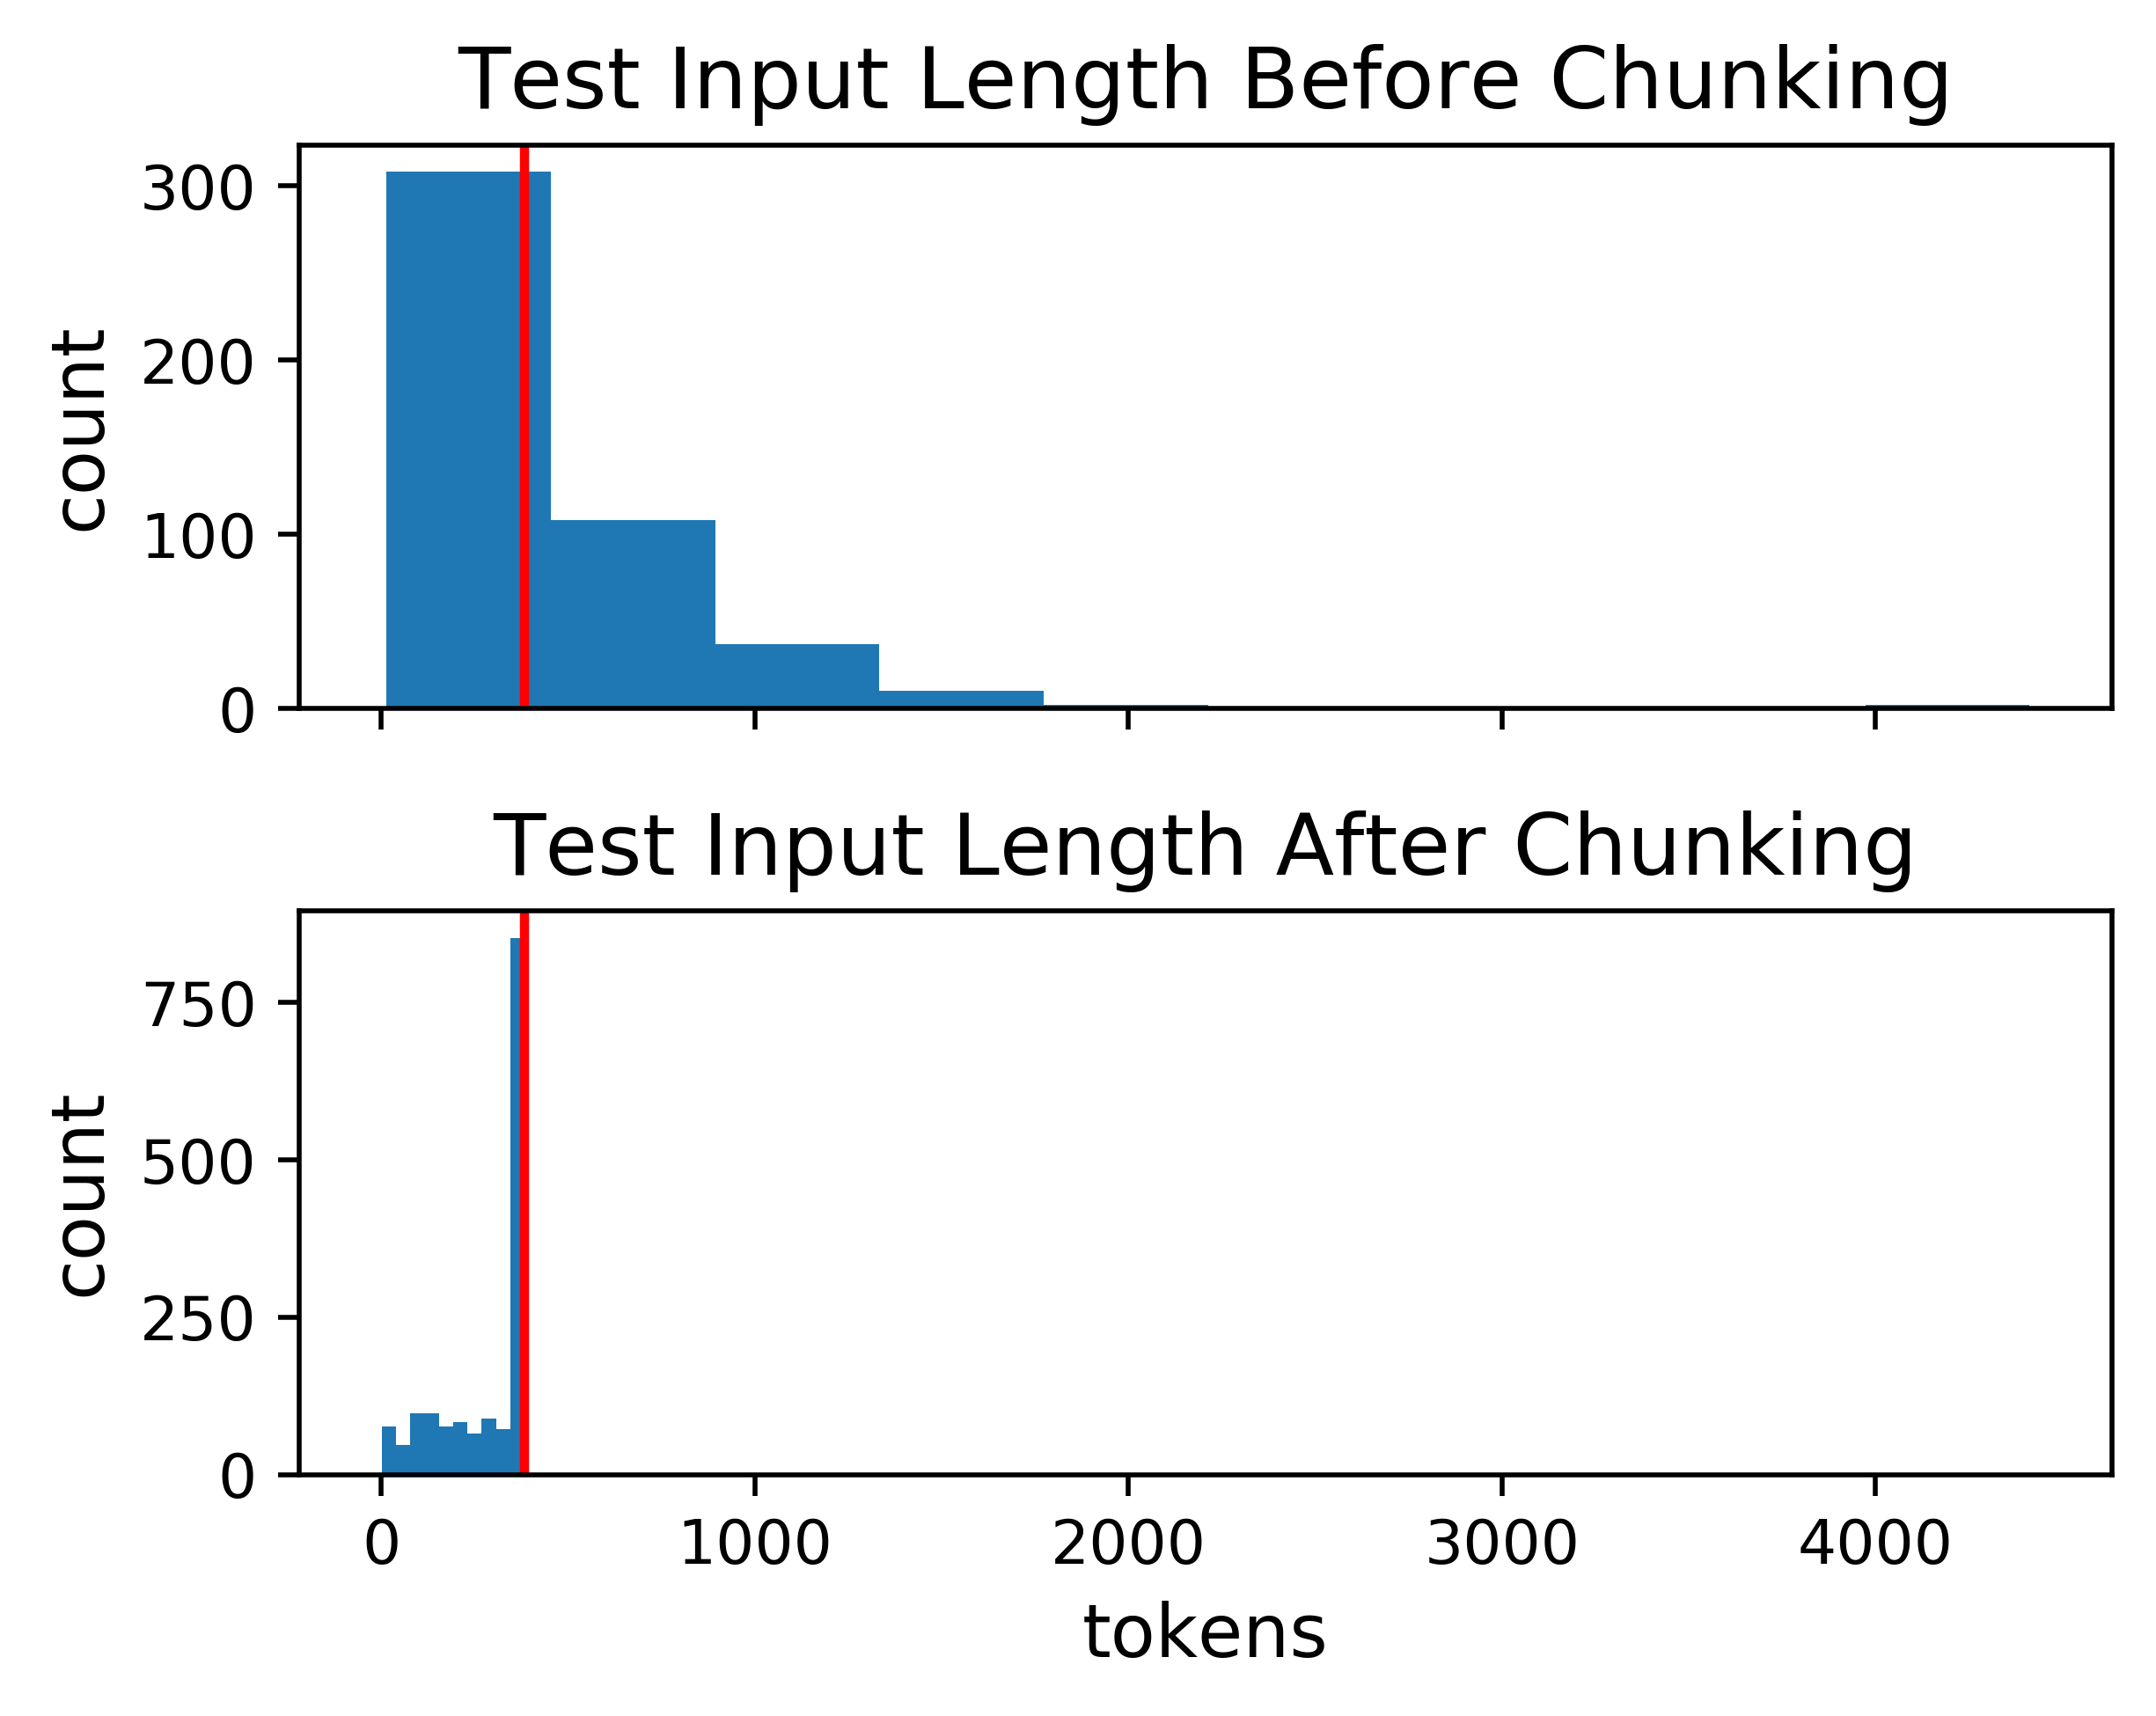

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[5, 4], sharex=True)
axs[0].hist(list(testDf["len1"]) + list(testDf["len2"]))
axs[0].axvline(384, color="red")
axs[0].set_title("Test Input Length Before Chunking", size=14)
axs[0].set_ylabel("count", size=12)
axs[1].hist(list(testChunked["len1"]) + list(testChunked["len2"]))
axs[1].axvline(384, color="red")
axs[1].set_title("Test Input Length After Chunking", size=14)
axs[1].set_ylabel("count", size=12)
axs[1].set_xlabel("tokens", size=12)
plt.tight_layout()

Text(0.5, 0, 'tokens')

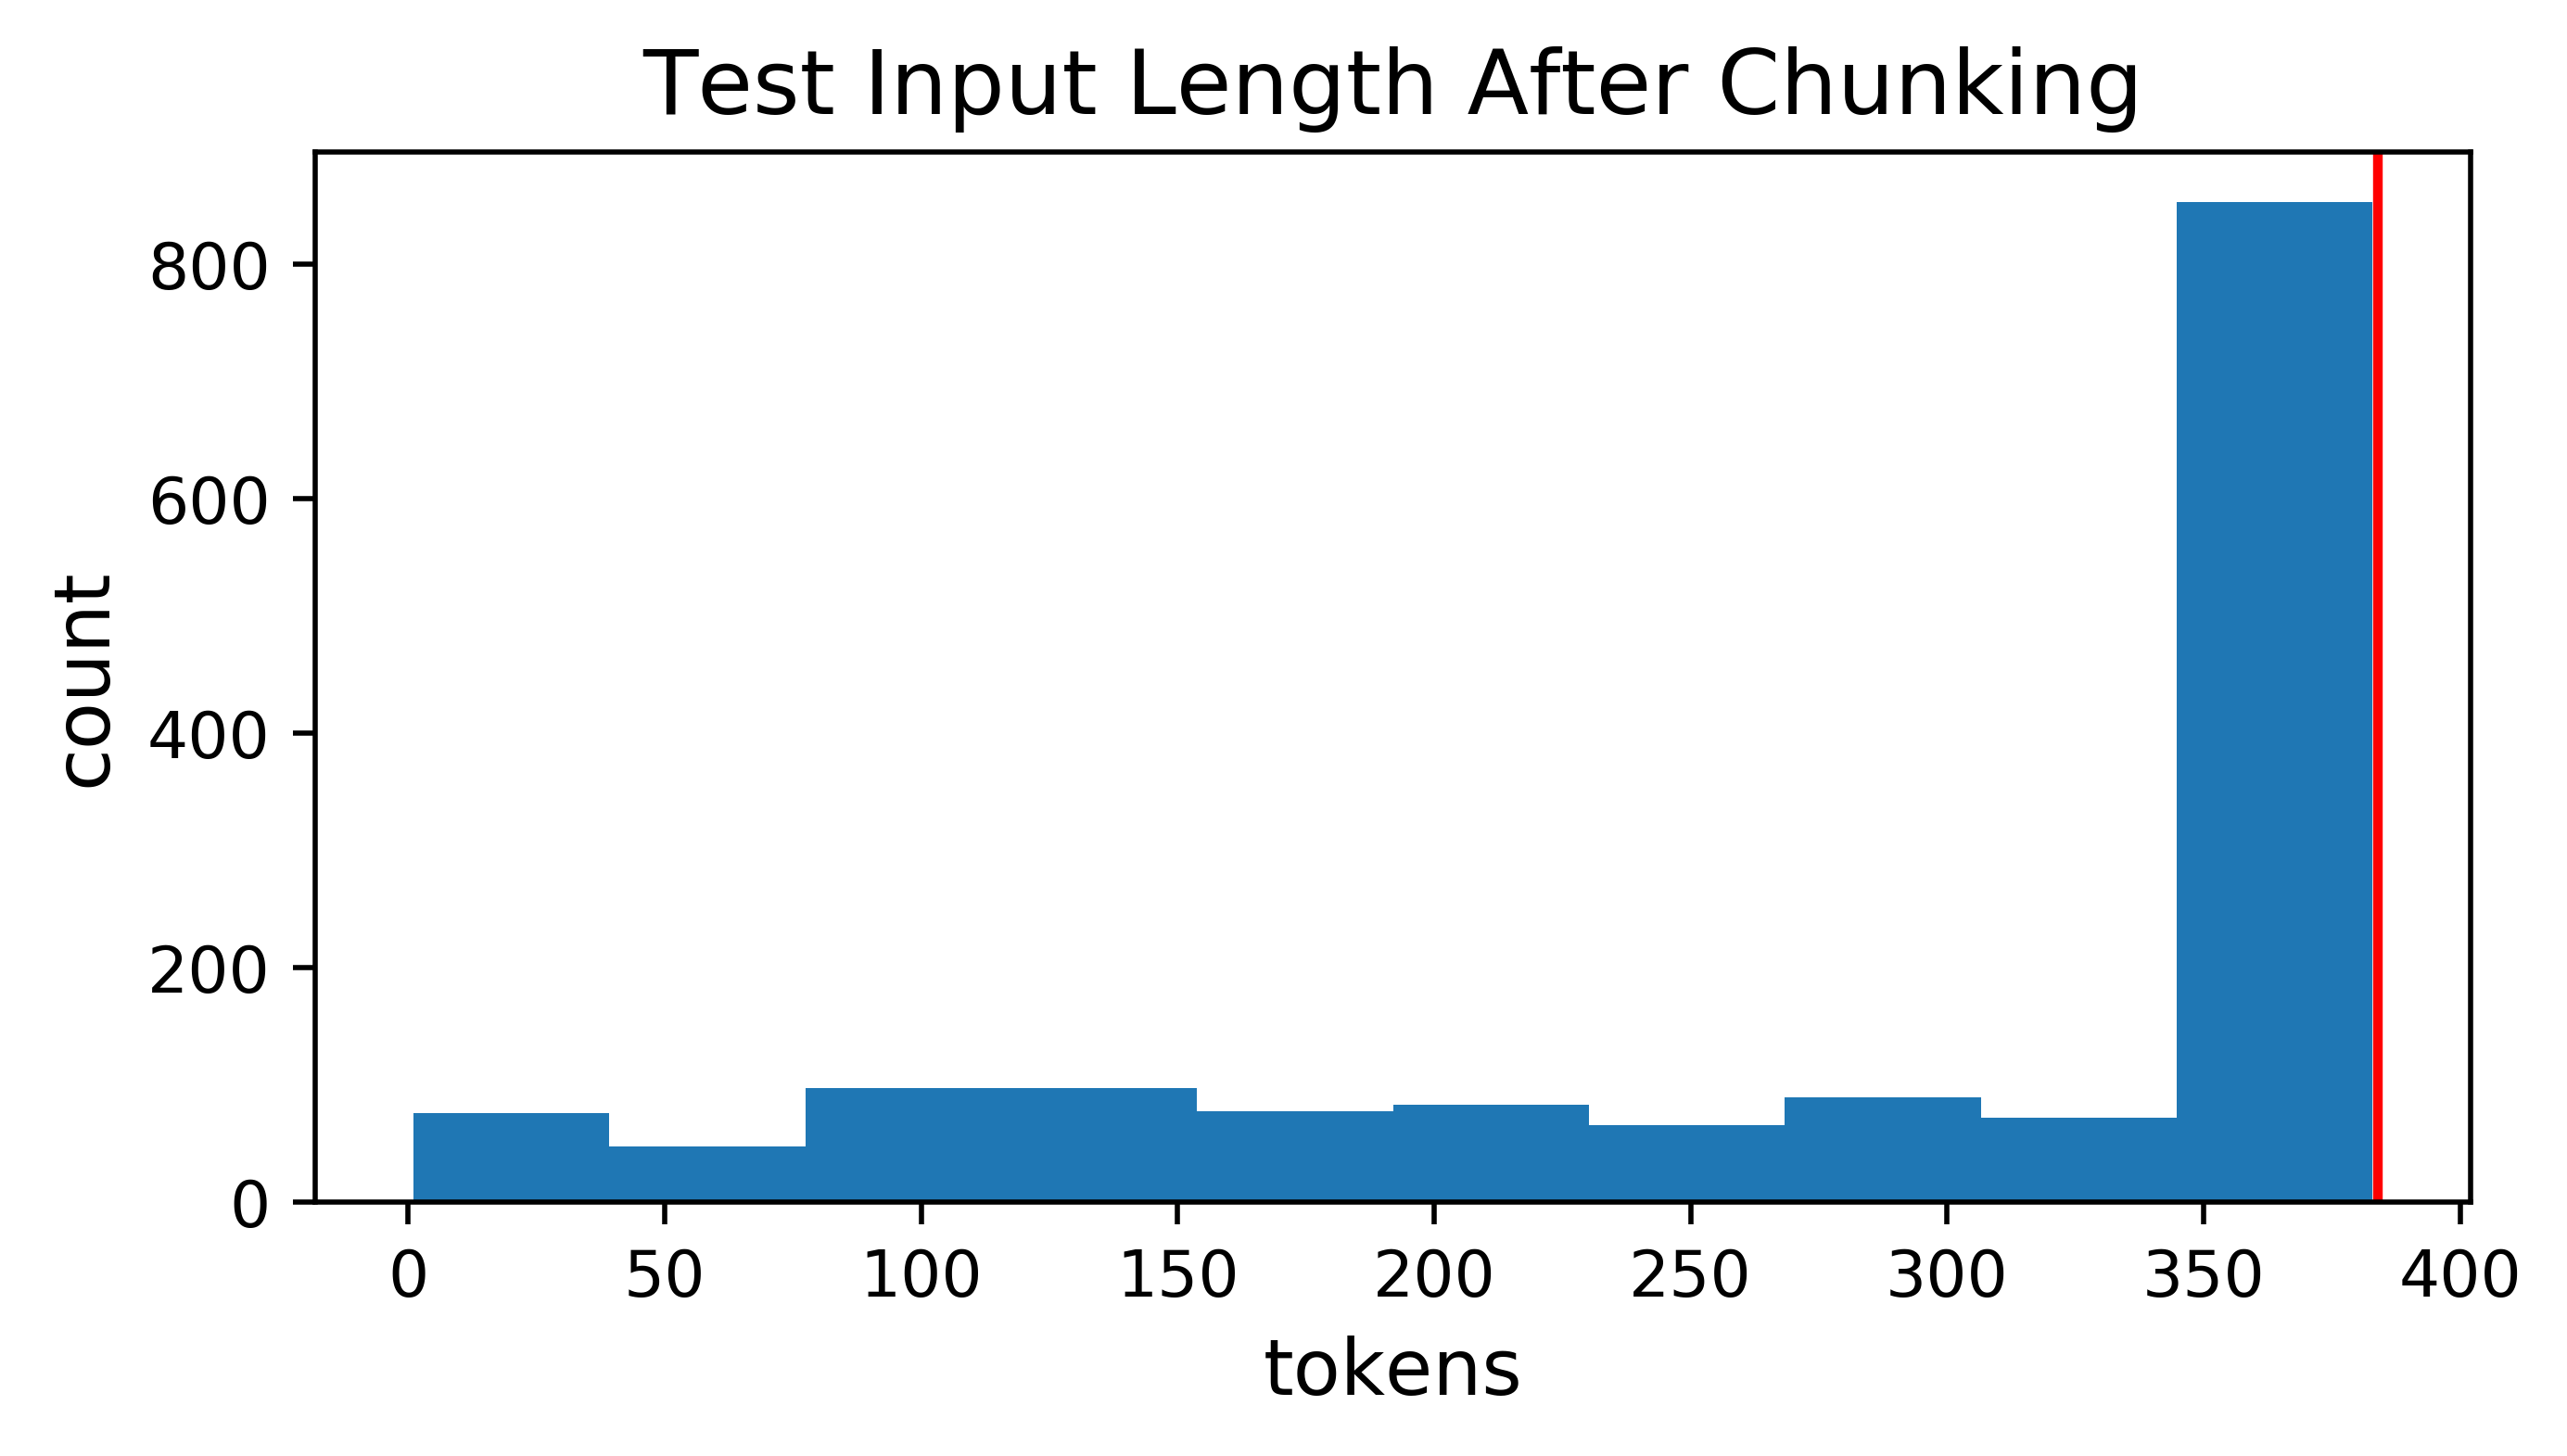

In [56]:
plt.subplots(figsize=[6, 3])
plt.hist(list(testChunked["len1"]) + list(testChunked["len2"]))
plt.axvline(384, color="red")
plt.title("Test Input Length After Chunking", size=14)
plt.ylabel("count", size=12)
plt.xlabel("tokens", size=12)

In [27]:
testChunked

,text1,text2,Overall,len1,len2
0,"DAVIE, FLA. (WSVN) - Police need help catching...","DEERFIELD BEACH, FLA. (WSVN) - A no-swim advis...",3.5,97,67
1,Govt officials confirm Trump can block US comp...,The latest huge unsecured cloud storage find i...,1.0,376,378
1,Govt officials confirm Trump can block US comp...,We have contacted the United States Computer E...,1.0,376,370
1,Govt officials confirm Trump can block US comp...,Business that amass and store consumer data in...,1.0,376,152
1,At the time of writing it has not been possibl...,The latest huge unsecured cloud storage find i...,1.0,173,378
...,...,...,...,...,...
232,Complaints continue of a shortage of US dollar...,Bank of Jamaica (BOJ) Governor Richard Byles h...,2.0,56,76
233,A growing number of businesses and individuals...,"NEW YORK >> In a world suffering a pandemic, c...",1.0,337,370
233,A growing number of businesses and individuals...,Banknotes that circulated in Europe and Asia ...,1.0,337,193
233,"""It's not impossible that there might be trace...","NEW YORK >> In a world suffering a pandemic, c...",1.0,303,370


In [28]:
#load model
modelPath = "/home/blitt/projects/localNews/models/sentEmbeddings/0.1-mpNetCosSimChunked/output"
model = SentenceTransformer(modelPath)

#compute embeddings for the test data and get correlation with ground truth 
text1 = list(testChunked["text1"])
text2 = list(testChunked["text2"])

#embed test text 
embed1 = model.encode(text1)
embed2 = model.encode(text2)

#get our cosine sims 
cos_scores = [] 
for i in range(len(embed1)): 
    cos_scores.append(util.cos_sim(embed1[i], embed2[i]))
cos_scores[:2]

#rescale ground truth 
preds = [float(item) for item in cos_scores]
gt = (5 - testChunked["Overall"]) / 4
print(np.corrcoef([preds, gt]))

#to dataframe 
comparisonMat = pd.DataFrame({"gt":gt, "preds":preds})


[[1.        0.6029034]
 [0.6029034 1.       ]]


In [29]:
testChunked["gt"] = gt
testChunked["preds"] = preds

In [63]:
chunkingResults = testChunked.reset_index().groupby("index").agg(list)
chunkingResults["avgPred"] = chunkingResults["preds"].apply(np.mean)
chunkingResults["maxPred"] = chunkingResults["preds"].apply(max)
chunkingResults["minPred"] = chunkingResults["preds"].apply(min)
chunkingResults["medianPred"] = chunkingResults["preds"].apply(np.median)

In [64]:
chunkingResults["gt"] = chunkingResults["gt"].apply(lambda x: x[0])

In [65]:
for colName in ["avgPred", "maxPred", "minPred", "medianPred"]:
    print(colName)
    print(np.corrcoef([list(chunkingResults[colName]), chunkingResults["gt"]]))

avgPred
[[1.         0.72534442]
 [0.72534442 1.        ]]
maxPred
[[1.         0.75278993]
 [0.75278993 1.        ]]
minPred
[[1.         0.63802127]
 [0.63802127 1.        ]]
medianPred
[[1.         0.72529854]
 [0.72529854 1.        ]]


Text(0.5, 1.0, 'Max Similarity Aggregation')

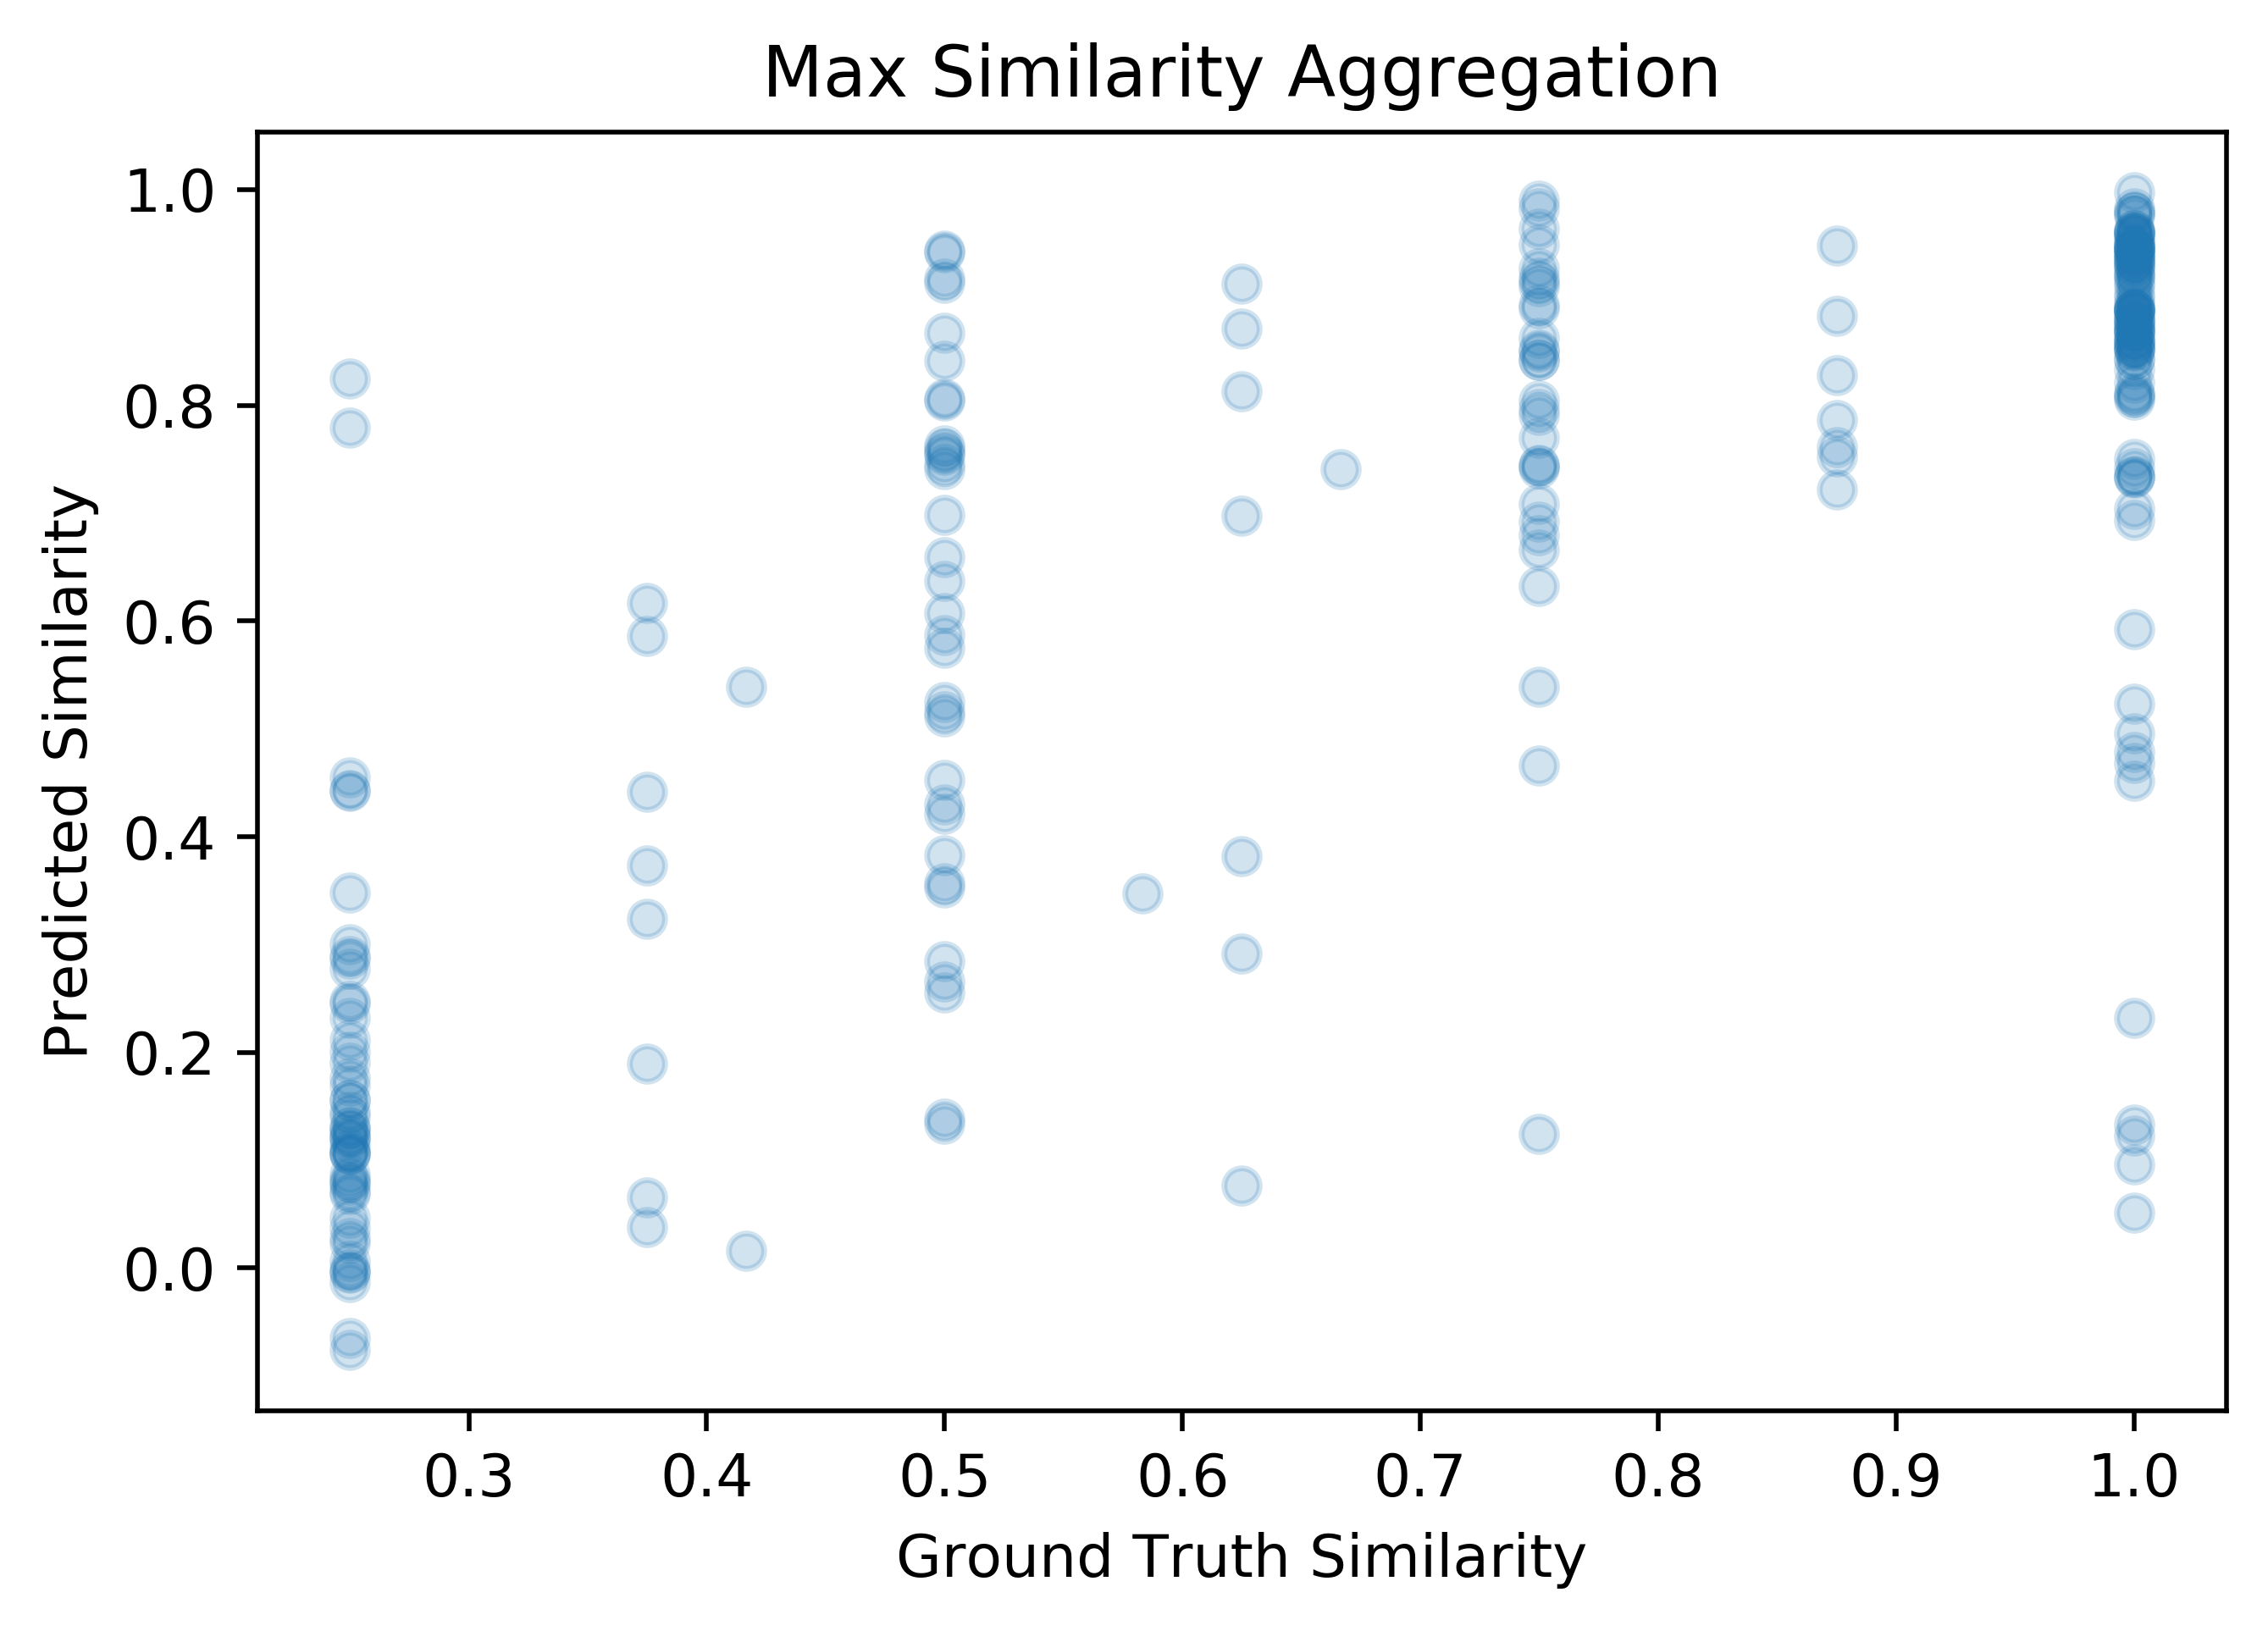

In [66]:
#compare ground truth on x axis to predictions on the y 
plt.scatter(chunkingResults["gt"], chunkingResults["maxPred"], alpha = .2)
plt.xlabel("Ground Truth Similarity")
plt.ylabel("Predicted Similarity")
plt.title("Max Similarity Aggregation")

In [68]:
chunkingResults.head(3)

,text1,text2,Overall,len1,len2,gt,preds,avgPred,maxPred,minPred,medianPred
index,,,,,,,,,,,
0,"[DAVIE, FLA. (WSVN) - Police need help catchin...","[DEERFIELD BEACH, FLA. (WSVN) - A no-swim advi...",[3.5],[97],[67],0.375,[0.037910088896751404],0.037910,0.037910,0.037910,0.037910
1,[Govt officials confirm Trump can block US com...,[The latest huge unsecured cloud storage find ...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[376, 376, 376, 173, 173, 173]","[378, 370, 152, 378, 370, 152]",1.000,"[0.6987565755844116, 0.6119673252105713, 0.331...",0.511708,0.734055,0.133902,0.586221
2,"[Ducks defenseman Erik Gudbranson, left, knock...",[Woody Guthrie's 1943 New Year's Resolutions a...,"[4.0, 4.0, 4.0, 4.0]","[380, 382, 362, 280]","[93, 93, 93, 93]",0.250,"[0.024910271167755127, 0.04079961031675339, 0....",0.053626,0.086521,0.024910,0.051537


In [82]:
#conf = sklearn.metrics.confusion_matrix(comparisonMat["gtIsSame"], comparisonMat["predIsSame"])
bGt = [int(item) for item in chunkingResults["gt"] >= .8]
bPred = [int(item) for item in chunkingResults["maxPred"] >= .8]
precision, recall, fbeta, support = sklearn.metrics.precision_recall_fscore_support(bGt, bPred, average="binary")
print(precision)
print(recall)
print(fbeta)

0.7383177570093458
0.7821782178217822
0.7596153846153846


In [34]:
#create cutoff and get predictions/gt for binary classification problem 
cutoff = .6

comparisonMat["gtIsSame"] = comparisonMat["gt"] >= .8
comparisonMat["gtIsSame"] = comparisonMat["gtIsSame"].astype(int)

comparisonMat["predIsSame"] = comparisonMat["preds"] >= .8
comparisonMat["predIsSame"] = comparisonMat["predIsSame"].astype(int)
comparisonMat

,gt,preds,gtIsSame,predIsSame
0,0.375,0.037910,0,0
1,1.000,0.698757,1,0
1,1.000,0.611967,1,0
1,1.000,0.331095,1,0
1,1.000,0.560475,1,0
...,...,...,...,...
232,0.750,0.849945,0,1
233,1.000,0.959828,1,1
233,1.000,0.813010,1,1
233,1.000,0.777740,1,0


In [ ]:
#TODO/NOTE: we can find cutoffs where precision and recall are very good. How do we think of a best value to pick..? 

In [ ]:
#confusion matrix 
conf = sklearn.metrics.confusion_matrix(comparisonMat["gtIsSame"], comparisonMat["predIsSame"])

#unpack conf matrix. Get accuracy 
acc = (conf[0,0] + conf[1, 1] ) / (len(comparisonMat))
tn, fp, fn, tp = conf.ravel()

#get precision, recall, f1
precision = (tp) / (tp + fp)
print("precision: " + str(precision))
recall = (tp) / (tp + fn)
print("recall: " + str(recall))
f1 = 2 * (precision * recall) / (precision + recall)
print("f1: " + str(f1))